In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import  ConfusionMatrixDisplay,confusion_matrix,classification_report

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


In [2]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


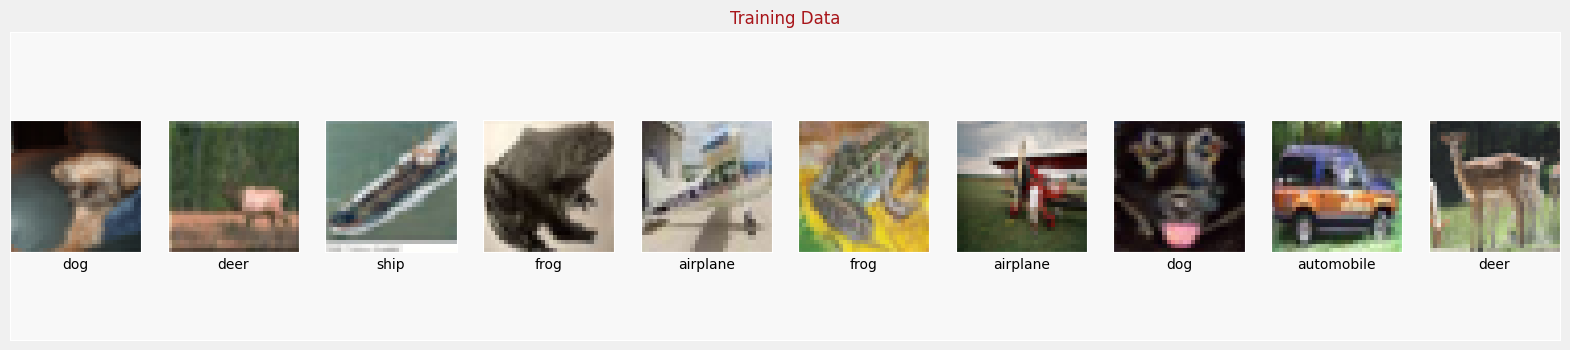

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )

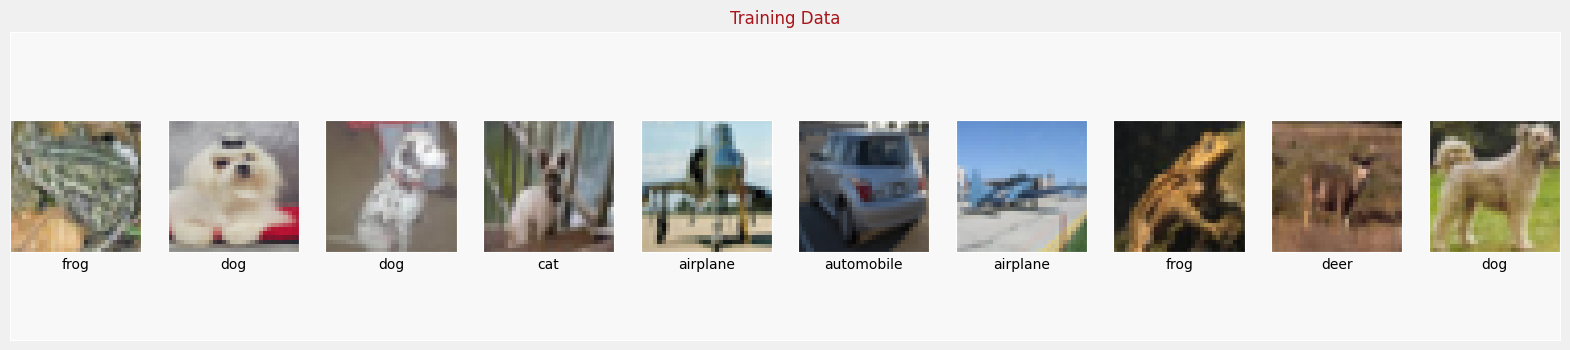

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [7]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [8]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [9]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [10]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/3
782/782 [==============================] - 547s 659ms/step - loss: 0.3971 - accuracy: 0.8694 - val_loss: 0.2545 - val_accuracy: 0.9147
Epoch 2/3
782/782 [==============================] - 531s 679ms/step - loss: 0.1014 - accuracy: 0.9668 - val_loss: 0.1704 - val_accuracy: 0.9448
Epoch 3/3
782/782 [==============================] - 531s 679ms/step - loss: 0.0338 - accuracy: 0.9908 - val_loss: 0.1752 - val_accuracy: 0.9491


In [11]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 27s 174ms/step - loss: 0.1752 - accuracy: 0.9491


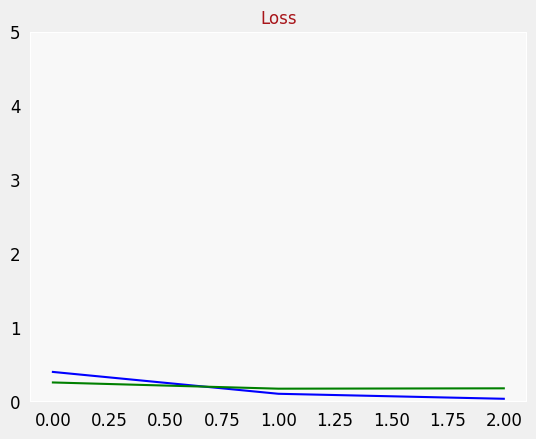

In [12]:
plot_metrics("loss", "Loss")

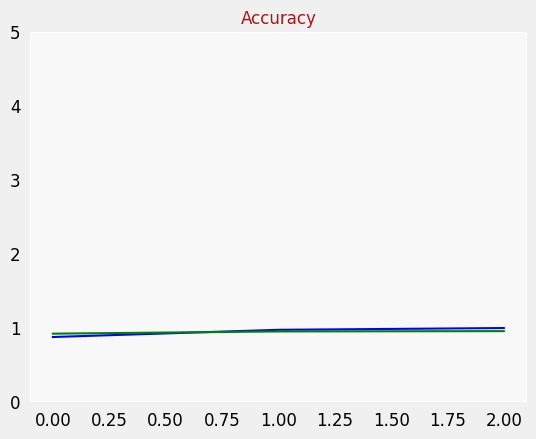

In [13]:
plot_metrics("accuracy", "Accuracy")

157/157 [==============================] - 29s 179ms/step


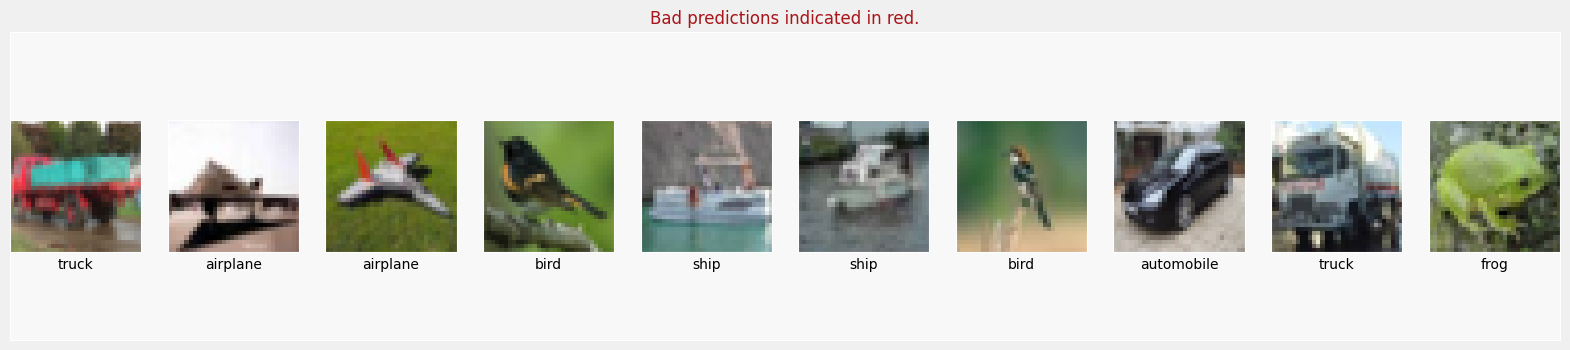

In [14]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


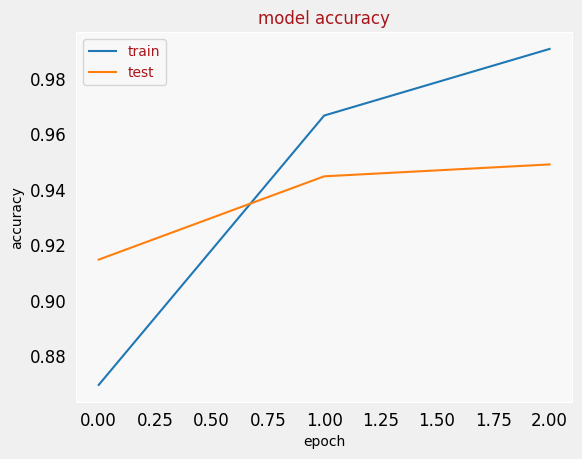

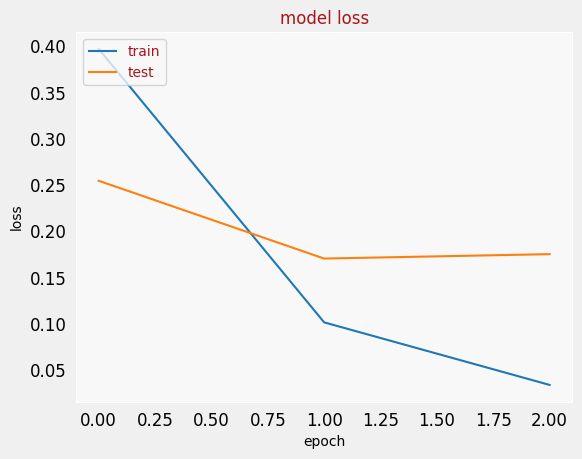

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
y_pred=model.predict(valid_X)
y_preds = y_pred.argmax(axis=1)
print(y_preds.shape)
print(validation_labels.shape)

313/313 [==============================] - 29s 88ms/step
(10000,)
(10000, 1)


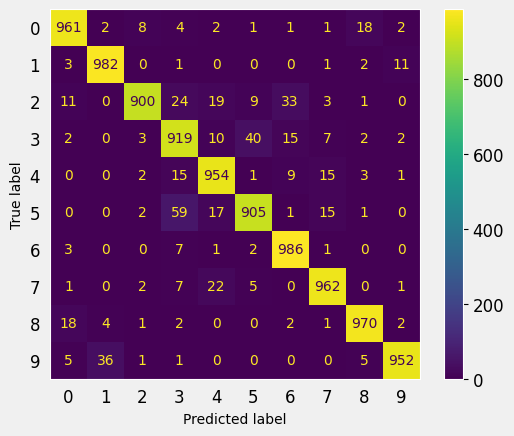

In [17]:
cm = confusion_matrix(validation_labels, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
print(classification_report(validation_labels, y_preds))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.96      0.98      0.97      1000
           2       0.98      0.90      0.94      1000
           3       0.88      0.92      0.90      1000
           4       0.93      0.95      0.94      1000
           5       0.94      0.91      0.92      1000
           6       0.94      0.99      0.96      1000
           7       0.96      0.96      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

